In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'/kaggle/input/techosmotr-images/techosmotr/train-t',
                                                 target_size = (224, 224),
                                                 batch_size = 5,
                                                 shuffle=False,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/kaggle/input/techosmotr-images/techosmotr/test-t',
                                            target_size = (224, 224),
                                            batch_size = 5,
                                            shuffle=False,
                                            class_mode = 'categorical')

STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_TEST=test_set.n//test_set.batch_size

Found 5266 images belonging to 2 classes.
Found 1319 images belonging to 2 classes.


In [3]:
IMAGE_SIZE = [224, 224]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
    shuffle = False


In [4]:
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
from keras import optimizers

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [6]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

#num_epochs = 1000
#num_batch_size = 32

checkpoint = ModelCheckpoint(filepath='VGG16-techosnotr.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer]

start = datetime.now()

history = model.fit(training_set, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = 10,  
                    shuffle=True)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
1053/1053 [==============================] - 48s 42ms/step - loss: 0.2806 - accuracy: 0.9084
Epoch 2/10
1053/1053 [==============================] - 43s 41ms/step - loss: 0.1575 - accuracy: 0.9458
Epoch 3/10
1053/1053 [==============================] - 43s 41ms/step - loss: 0.0768 - accuracy: 0.9740
Epoch 4/10
1053/1053 [==============================] - 43s 41ms/step - loss: 0.0504 - accuracy: 0.9814
Epoch 5/10
1053/1053 [==============================] - 43s 40ms/step - loss: 0.0440 - accuracy: 0.9863
Epoch 6/10
1053/1053 [==============================] - 43s 40ms/step - loss: 0.0361 - accuracy: 0.9907
Epoch 7/10
1053/1053 [==============================] - 43s 40ms/step - loss: 0.0328 - accuracy: 0.9924
Epoch 8/10
1053/1053 [==============================] - 43s 41ms/step - loss: 0.0246 - accuracy: 0.9939
Epoch 9/10
1053/1053 [==============================] - 42s 40ms/step - loss: 0.0234 - accuracy: 0.9970
Epoch 10/10
1053/1053 [==============================] - 42s 40m

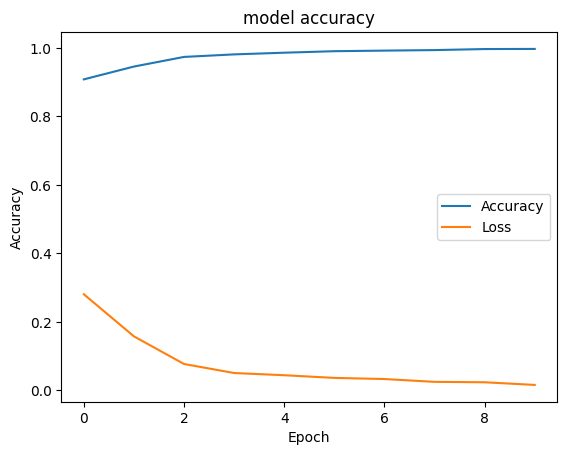

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Loss",])
plt.show()

In [8]:
results = model.evaluate(test_set, batch_size=128)
print("test loss, test acc:", results)


264/264 [==============================] - 12s 45ms/step - loss: 0.2309 - accuracy: 0.9553
test loss, test acc: [0.23091112077236176, 0.9552691578865051]


In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os


# Prepare and preprocess your new dataset
new_data_directory = '/kaggle/input/case-3-test/test'

# Get a list of all image files in the directory
image_files = [os.path.join(new_data_directory, filename) for filename in os.listdir(new_data_directory) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Initialize a list to store predicted labels
predicted_labels = []

for image_file in image_files:
    img = keras.preprocessing.image.load_img(image_file, target_size=(224, 224))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values if needed

    # Make predictions
    predictions = model.predict(img)
    predicted_label = np.argmax(predictions, axis=-1)

    # Append the predicted label to the list
    predicted_labels.append(predicted_label[0])

# Now, you have the predicted labels for your unlabeled images.

1/1 [==============================] - 0s 20ms/step


In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os


# Prepare and preprocess your new dataset
image_file = '/kaggle/input/techosmotr-images/techosmotr/train-t/good/70002285.jpeg'



img = keras.preprocessing.image.load_img(image_file, target_size=(224, 224))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values if needed

# Make predictions
predictions = model.predict(img)
predicted_label_image = np.argmax(predictions, axis=-1)


# Now, you have the predicted labels for your unlabeled images.

1/1 [==============================] - 0s 19ms/step


In [11]:
predicted_label_image

array([1])

In [12]:
import numpy as np

# Example array with zeros and ones
original_array = np.array(predicted_labels)

# Invert ones and zeros
inverted_array = 1 - original_array

# Alternatively, you can use XOR (^) operation
inverted_array = original_array ^ 1

# The 'inverted_array' now contains the swapped values
print(inverted_array)


[1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1
 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0
 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1
 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0
 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1
 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 

In [13]:
import os

# List of example image file names
file_names = ['kaggle/test/71145.png', 'kaggle/test/8234.jpg', 'kaggle/test/9001.png']

# Extract numeric parts from all file names in the list
numeric_parts = [os.path.splitext(os.path.basename(image_file))[0] for image_file in image_files]

# 'numeric_parts' will contain ['71145', '8234', '9001']
print(numeric_parts)


['78942502', '72473767', '72306150', '79367589', '76954750', '79193540', '70563942', '73088955', '71260080', '77467597', '73029556', '74939922', '70566487', '72177356', '76862750', '78126885', '73619219', '75061110', '79793732', '70070242', '72441097', '76973296', '72722867', '78749745', '78968496', '75731194', '76102039', '74118460', '79204262', '79641816', '79493430', '71389581', '71450381', '78203987', '71801587', '76950703', '75869877', '70102740', '78455539', '75152199', '75147452', '70517733', '75247488', '70887562', '71351163', '70995766', '77843279', '79846760', '77110790', '75140372', '77355848', '70288812', '77513741', '78254113', '78824745', '72565733', '70644789', '75275546', '79416473', '75407878', '74477562', '78235074', '77652840', '73345461', '76114126', '73993408', '79780926', '75773965', '75034107', '70620269', '75170767', '70232167', '78927595', '77180592', '76475211', '78568950', '73364708', '76822638', '73345628', '74376828', '73543739', '75740149', '76196047', '77

In [14]:
import pandas as pd

# Create a DataFrame with two columns
df = pd.DataFrame({'file_index': numeric_parts, 'class': inverted_array})

# Access the data in the DataFrame
print(df)




    file_index  class
0     78942502      1
1     72473767      0
2     72306150      1
3     79367589      1
4     76954750      0
..         ...    ...
772   79797333      0
773   76019137      1
774   78672316      0
775   70007467      1
776   73885075      0

[777 rows x 2 columns]


In [15]:
# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)

In [16]:
model.save('model_vgg_techosmotr.h5')